# Setpoint Reinforcement Learning
*Target a score for generalized control*

---


Concrètement, nous entrainons plusieurs algorithmes d'apprentissage par renforcement sur des environnements LTI ayant les specificitées suivantes :

**Observations :** Acquisition d'une variable $s$ de l'ensemble des états $S$ et actions $A$. Ensuite, nous appliquons la transformation suivante : $  (S,A) \rightarrow \left \{ a_{(i,t-1)}, s_{(i,t-1)}, s_{(i,t)}, s_{c(i,t+1)} \right \} $. Avec $s_{c(i,t+1)}$ la consigne de l'état choisi et $a_{(i,t-1)}$, l'action au temps précedent.

**Récompenses :** Système de récompense en fonction de l'écart par rapport à la consigne, doit suivre un critère $L_{1}, L_{2}$. La moyenne d'un controle aléatoire doit être positif.

**Nous utiliserons ici Stable Baseline pour tester l'entrainement**

Controleur naïf :

$$a_{t} = sgn(a_{t-1}) \cdot sgn(s_{t} - s_{t-1}) \cdot sgn(s_{c, t+1} - s_{t})$$

In [ ]:
!pip3 install control --quiet
!pip3 install gymnasium --quiet
!pip3 install stable-baselines3[extra] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 13.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.7 MB/s eta 0:00:00


*(masquer cette partie)*

---

## Code de l'environement

In [ ]:
import pylab as plt

In [ ]:
import gymnasium as gym
import numpy as np, control as ct
import pandas as pd
import scipy.ndimage as sm
import scipy.optimize as so

from tqdm import tqdm

from gymnasium import spaces

class LinearSystemControl(gym.Env):
    def __init__(self, config={
                  "env_mode":1,
                  "update_setpoint":True,
                  "reset_X_start":True,
                  "tf":None,
                  "reset":True,
                  "isdiscrete": False,
                  "SpaceState":None,
                  "setpoint":None,
                  "env_config":None,
                  "modular":False,
                  "return_action":True,
                  "return_speed":False,
                  "order":3,
                  "t":10,
                  "N":250}
                 ):
        self.lti_config = config
        self.mode = config["env_mode"]
        self.definedSet = config["setpoint"]
        self._order = config["order"]
        if isinstance(config["isdiscrete"], bool):
          self._isdiscrete = config["isdiscrete"]
          self.N_space = 3 # by default
        else :
          self._isdiscrete = config["isdiscrete"][0]
          self.N_space = config["isdiscrete"][1]
        self._update_setpoint = config["update_setpoint"]
        self._reset = config["reset"]
        self._return_action = config["return_action"]
        self._reset_start = config["reset_X_start"]
        self._return_speed = config["return_speed"]
        self._rotate = config["modular"]
        self._max_episode_steps = config["N"]
        self.T = config["t"]
        # first action
        self.U = list(np.random.randint(-1,2,2))
        # sim
        self._elapsed_steps = 0
        self._life = 3
        self.previous_action = 0.
        # parameter
        if self._isdiscrete :
            self.action_space = spaces.Discrete(self.N_space)  # {-1, 0, 1} --> to upgrade with N : {-1,1}, {-1,0,1}, {-1, -0.33, +0.33, 1}, {-1, -0.5, 0, 0.5, 1}
        else :
            self.action_space = spaces.Box(low=-1., high=1., shape=(1,), dtype=np.float32) # [-1;1]
        self.dim_obs = 4 if self._return_action else 3
        # StateSpace
        self.ss = pd.Series({"i":0, "s":0, "A":np.array(1), "B":np.array(1), "C":np.array(1), "D":np.array(1)})  if not(isinstance(config["SpaceState"], pd.Series)) else config["SpaceState"]
        # IOSystem U={0,1}, X0=1
        self.dydt = []
        self.X_start = 0. #only the first
        self.time = np.linspace(0, self.T, self._max_episode_steps)
        if config["tf"] == None :
          self.sys = self.define_LinearIO(self.ss)
        else :
          self.sys = self.generate_ss_from_tf(*config["tf"])
        # define setpoint
        self.set_setpoint()

    ############ Parameter Part
    def signal_generator(self, N, epsilon=0.05):
        a = (1 - 2*epsilon)
        # smoother
        s = np.random.randint(1,N//10)
        # random
        r = np.random.random(N)
        # smooth signal
        smooth = sm.gaussian_filter1d(r, s)
        n = a*(smooth - smooth.min())/(smooth.max() - smooth.min()) + epsilon
        return n

    def set_setpoint(self, epsilon=0.05):
        # mode : consigne (setpoint in  [0+a,1-a])
        if self.mode == 0 :
            if self.definedSet == None :
              self.setpoint = (self.setmin + self.setmax)/2.
            else :
              self.setpoint = self.definedSet
        elif self.mode == 1 :
            self.setpoint = np.random.uniform(self.setmin + 2*self.D, self.setmax - 2*self.D)
        else :
            consigne = self.signal_generator(self._max_episode_steps, epsilon=self.D) # def pour nb max iter
            self.all_setpoint = (self.setmax - self.setmin)*consigne + self.setmin
            self.setpoint = self.all_setpoint[self._elapsed_steps] # prends la derniere valeur

    def define_Boundary(self, sys, d=0.05) :
        # calculate boundary
        _, Y_g = ct.forced_response(sys, self.time, U=-1, X0=self.X_start)
        _, Y_h = ct.forced_response(sys, self.time, U=1, X0=self.X_start)
        # sign in limit --> for order sup 1, find zeros bounds for generalization (zeros = len(fsolve(Y_g - Y_h, [0, self._max_episode_steps])))
        self.sign = (1. if Y_h[-1] > Y_g[-1] else -1.)
        # boundary
        self.min, self.max = min(Y_g.min(), Y_h.min()), max(Y_g.max(),Y_h.max())
        # setpoint limit (squeeze theroem : g < f < h) --> NO
        self.setmin, self.setmax = min(np.median(Y_h), np.median(Y_g)), max(np.median(Y_h), np.median(Y_g))
        # apply
        #self.observation_space = spaces.Box(low=self.min, high=self.max, shape=(self.dim_obs,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.dim_obs,), dtype=np.float32)
        # basic error 10 %
        self.D = d*(self.setmax - self.setmin)

    ############ Model Part
    def generate_ss_from_tf(self, tf=[([1],[1,1]), ([-1],[1,1])], parameter=[1./2, 1./2]):
        # extract ft & sp
        if isinstance(tf, tuple):
          tf_ = tf
          num , den = tf_
          self.setpoint = self.definedSet = parameter
        else :
          if isinstance(parameter, list):
            if len(tf) != len(parameter) :
              idx = np.random.choice(len(tf))
              print('[WARNING] Incorrect parameter for multiple tf')
            else : idx = np.random.choice(len(tf), p=parameter)
            self.setpoint = self.definedSet = parameter[idx] # not consistent for many cases, but necessary for operation
          else :
            idx = np.random.choice(len(tf))
            self.setpoint = self.definedSet = parameter
          tf_ = tf[idx]
          if tf_[0] != "rss" :
            num , den = tf_
        # create system
        if tf_[0] == "rss" :
          sys = ct.rss(tf_[1])
          if self.mode == 0 : print('[WARNING] Incorrect mode if rss')
        else :
          if isinstance(num, str) :
            num = np.random.choice([-1,1])*(.1+.9*np.random.random())
            if self.mode == 0 : print('[WARNING] Incorrect mode if a/(1+x)')
          sys = ct.TransferFunction(num,den)
          sys = ct.tf2ss(sys)
        # start
        if self._reset_start :
          self.X_start = np.random.choice([-1.,0.,1.])
        # extract parameter
        self.ss["A"], self.ss["B"], self.ss["C"], self.ss["D"] = sys.A, sys.B, sys.C, sys.D
        self.ss["i"], self.ss["s"] = 1, sys.nstates
        # bound and simulation parameter
        self.define_Boundary(sys)
        # save
        self._order = self.ss["s"]
        return sys

    def define_LinearIO(self, ss, d=0.05):
        if ss.i == 0 :
          ss["s"] = self._order
          sys = ct.rss(self._order)
          ss["A"], ss["B"], ss["C"], ss["D"] = sys.A, sys.B, sys.C, sys.D
        else :
          sys = ct.StateSpace(ss.A,ss.B,ss.C,ss.D)
          self._order = ss["s"]
        if self._reset_start :
          self.X_start = np.random.choice([-1.,0.,1.])
        # bound and simulation parameter
        self.define_Boundary(sys, d)
        return sys

    ############ Simulation Part
    def reset(self, seed=None, options=None):
        self._life = 3
        self._elapsed_steps, T = 0, self.time[0:2]
        # re-init
        if self._reset :
          if self.lti_config["tf"] == None :
            self.sys = self.define_LinearIO(self.ss)
          else :
            self.sys = self.generate_ss_from_tf(*self.lti_config["tf"])
        if self._update_setpoint :
          self.set_setpoint()
        # 1st step
        self.U = list(np.random.randint(-1,2,2))
        T, Y, X = ct.forced_response(self.sys, T, U=self.U, X0=self.X_start, return_x=True)
        self.V = self.U
        # update
        self._elapsed_steps += 1
        self.X = X[:,1]
        self.previous_action = self.U[-1]
        #return <obs>
        if self._return_speed :
          self.dydt = [(Y[1] - Y[0]) / (T[1] - T[0])]
          obs = [[Y[0],self.dydt[0]],[Y[1],self.dydt[0]],[self.setpoint,0]]
          if self._return_action :
            obs = [[self.previous_action, 0]] + obs
        else :
          obs = [Y[0], Y[1], self.setpoint]
          if self._return_action :
            obs = [self.previous_action] + obs
        return np.array(obs), {}

    def step(self, action):
        done = False
        # continuous or discrete
        if self._isdiscrete :
            action = 2*(action / (self.N_space - 1.)) - 1. # {-1,1}, {-1,0,1}, {-1, -0.33, +0.33, 1}, {-1, -0.5, 0, 0.5, 1}, (...)
        else :
            action = float(action)
            if self._rotate :
              action = 1.5*np.sin(action)
            else :
              action = min(max(action,-1.5),1.5)
        # update input
        T = self.time[self._elapsed_steps:self._elapsed_steps+2]
        self.V = [self.V[-1], action]
        # calculate
        T, Y, X = ct.forced_response(self.sys, T, U=self.V, X0=self.X, return_x=True)
        # update output
        self._elapsed_steps += 1
        self.X = X[:,1]
        # reward : Custom reward with HubberLoss (setpoint(t))
        if Y[-1] > (self.setpoint - self.D) and Y[-1] < (self.setpoint + self.D) :
            reward = 1.
        elif Y[-1] > (self.setpoint - 2*self.D) and Y[-1] < (self.setpoint + 2*self.D) :
            reward = 0.5
        else :
            reward = 0.
        # outlimit
        if (Y[-1] < self.min) or (Y[-1] > self.max) :
            reward = -1.
            self._life -= 1.
            if self._life == 0 :
              reward = -10.
              done = True
        # limit
        if self._elapsed_steps == self._max_episode_steps - 1 :
            done = True
        # update setpoint
        setpoint = self.setpoint
        if self.mode == 2 :
          self.setpoint = self.all_setpoint[self._elapsed_steps]
        # new state (setpoint(t+1))
        if self._return_speed :
          self.dydt = [self.dydt[-1]] + [(Y[1] - Y[0]) / (T[1] - T[0])]
          dsdt = (self.setpoint - setpoint) / (T[1] - self.time[self._elapsed_steps])
          obs = [[Y[0],self.dydt[0]],[Y[1],self.dydt[1]],[self.setpoint, dsdt]]
          if self._return_action :
            dadt = (action - self.previous_action) / (T[1] - self.time[self._elapsed_steps])
            obs = [[action, dadt]] + obs
        else :
          obs = [Y[0], Y[1], self.setpoint]
          if self._return_action :
            obs = [action] + obs
        state = np.array(obs)
        # update action
        self.previous_action = action
        # return <obs>, <reward: float>, <done: bool>, <info: dict>
        info = {}
        return state, reward, done, done, info

## Parametre de l'environnement d'entrainement

In [ ]:
lti_config_od1_m1_dqn = {
    "env_mode":1,
    "update_setpoint":True,
    "reset_X_start":True,
    "reset":True,
    "isdiscrete":(True,2), #False
    "SpaceState":None,
    "tf": (([1],[1,1]),), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":1, # if no tf
    "t":10,
    "N":250
}

lti_config_od2_m1_dqn = {
    "env_mode":1,
    "update_setpoint":True,
    "reset_X_start":False,
    "reset":True,
    "isdiscrete":(True,2), #False
    "SpaceState":None,
    "tf": (([1],[1,-1./4,1]),), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":1, # if no tf
    "t":10,
    "N":250
}

lti_config_od1_m1_dqn_easy = {
    "env_mode":1,
    "update_setpoint":True,
    "reset_X_start":False, # if True, it's Hard for train ! You can use for evaluation
    "reset":True,
    "isdiscrete":True, #False
    "SpaceState":None,
    "tf": (([1],[1,1]),), #
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":1, # if no tf
    "t":10,
    "N":250
}

lti_config_3tf_m1_dqn = {
    "env_mode":1,
    "update_setpoint":True,
    "reset_X_start":True,
    "reset":True,
    "isdiscrete":True, #False
    "SpaceState":None,
    "tf": ([([1],[1,1]), ('a',[1,1]), ('rss',2)],1./2), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":1, # if no tf
    "t":10,
    "N":250
}

## not ok, train only for [1]/[1,1]
lti_config_3tf_m1_dqn_easy = {
    "env_mode":1,
    "update_setpoint":True,
    "reset_X_start":False,
    "reset":True,
    "isdiscrete":True, #False
    "SpaceState":None,
    "tf": ([([1],[1,1]), ('a',[1,1]), ('rss',2)],1./2), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":1, # if no tf
    "t":10,
    "N":250
}

## compare for all config
lti_config_4tf_m1_dqn_easy = {
    "env_mode":1,
    "update_setpoint":True,
    "reset_X_start":False,
    "reset":True,
    "isdiscrete":(True,2), #False
    "SpaceState":None,
    "tf": ([([1],[1,1]), ([-1],[1,1]), ('a',[1,1]), ('rss',3)],1./2), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":1, # if no tf
    "t":10,
    "N":250
}


# 2tf it's hardcore with rss2 (rwd mean final = 25) --> test for V3 (np.choice)
lti_config_2tf_m1_dqn_easy = {
    "env_mode":1,
    "update_setpoint":True,
    "reset_X_start":False,
    "reset":True,
    "isdiscrete": (True,2), #False
    "SpaceState":None,
    "tf": ([('a',[1,1]), ('rss',2)],1./2), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":1, # if no tf
    "t":10,
    "N":250
}

In [ ]:
lti_config_ss_mX_algo = lti_config_od2_m1_dqn #lti_config_2tf_m1_dqn_easy #lti_config_od1_m1_dqn_easy #lti_config_od1_m1_dqn #lti_config_3tf_m1_dqn # lti_config_tf1_mX_td3

In [ ]:
# Create the Gym environment
env = LinearSystemControl(lti_config_ss_mX_algo)

In [ ]:
# verif
_ = env.reset()
env.sys

StateSpace(array([[ 0.25, -1.  ],
       [ 1.  ,  0.  ]]), array([[1.],
       [0.]]), array([[0., 1.]]), array([[0.]]))


*(masquer cette partie)*

---

## Test environment & config


### Tout-ou-Rien "généralisé naïf"

In [ ]:
# mode
random = False
perturb = True
# simulation
state, _ = env.reset()
Y = [state[2:]]
A, R = [],[]
for i in range(env._max_episode_steps-2) :
  if random :
    action = env.action_space.sample()
  else :
    #action = np.sign(state[0])*np.sign(state[2]-state[1])*np.sign(state[3]-state[2]) + env._isdiscrete
    #action = np.sign(state[0])*np.sign(np.sign(state[2]-state[1])+np.sign(state[3]-state[2])) + env._isdiscrete
    #action = env.sign*np.sign(np.sign(state[2]-state[1])+np.sign(state[3]-state[2])) + env._isdiscrete
    #action = np.sign(state[0])*np.sign(state[3]-state[1]) + env._isdiscrete
    action = env.sign*np.sign(state[3]-state[2]) + env._isdiscrete # boolean ToR (sliding mode 1)
    #action = np.sign(state[3]-state[2]) + env._isdiscrete # ToR classic
  if perturb :
    if np.random.random() > 0.999 :
      action = env.action_space.sample()
  state, reward, done, _, info = env.step(action)
  A += [state[0]]
  Y += [state[2:]]
  R += [reward]
  if done : break
print(state, len(R), np.sum(R))
# compare
T_OUT, Y_p = ct.forced_response(env.sys, env.time, U=1, X0=env.X_start)
T_OUT, Y_m = ct.forced_response(env.sys, env.time, U=-1, X0=env.X_start)
# plot
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(T_OUT[:len(Y)], Y);
axs[0].plot(T_OUT, Y_p)
axs[0].plot(T_OUT, Y_m);
#axs[0].plot(T_OUT[1:len(Y)], A, alpha=0.3)
axs[1].plot(T_OUT[1:len(Y)], R)
#plt.savefig(dirpath+"figure_test_lti.svg")
plt.show()
env.sys

## Train

Use Stable Baseline 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from stable_baselines3 import DQN
import pandas as pd
from tqdm.notebook import tqdm

In [ ]:
model_param = {"policy" : "MlpPolicy",
               #"env" : LinearSystemControl(lti_config_4tf_m1_dqn_easy),
               "env" : LinearSystemControl(lti_config_od1_m1_dqn),
               "verbose": 0,
               "exploration_final_eps": 0.1,
               "exploration_fraction": 0.2,
               "target_update_interval": 5000,
               }

In [ ]:
#model = DQN("MlpPolicy", env,verbose=2,exploration_final_eps=0.1, exploration_fraction=0.2)#, target_update_interval=5000,)
model = DQN(**model_param)

https://araffin.github.io/post/sb3/

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import ProgressBarCallback
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        self.data = {'r':[],'l':[],'t':[],"s":[]}

    def _on_step(self) -> bool:
        if len(self.model.ep_info_buffer) > 0:
          d = self.model.ep_info_buffer[-1].copy()
          d["s"] = self.num_timesteps
          for key in self.data :
            self.data[key].append(d[key])
        return True

    def to_dataframe(self): # ne pas itérer sur pandas
        return pd.DataFrame(self.data)

In [ ]:
callback = CustomCallback()
# Train the agent
model.learn(total_timesteps=int(1e5))#, progress_bar=True)#TqdmCallbackcallback=[callback,TqdmCallback()])

## Evaluate

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
# Separate env for evaluation
eval_env = LinearSystemControl(lti_config_od1_m1_dqn)

In [ ]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)

print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward=241.95 +/- 5.424251100382429


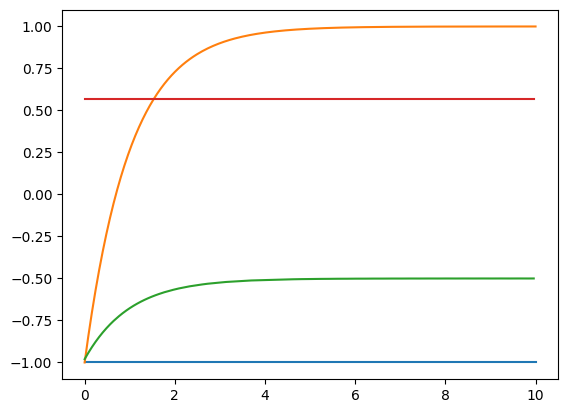

StateSpace(array([[-1.]]), array([[1.]]), array([[1.]]), array([[0.]]))

In [ ]:
# simulation
s = []
for j in range(1):
  state, _ = eval_env.reset()
  s += [[state]]
  for i in range(env._max_episode_steps-2) :
    action, _ = model.predict(state, deterministic=True)
    state, reward, done, _, info = eval_env.step(action)
    s += [[state]]
    if done: break
s = np.concatenate(s)
# limit
T_OUT, Y_p = ct.forced_response(eval_env.sys, env.time, U=1, X0=eval_env.X_start)
T_OUT, Y_m = ct.forced_response(eval_env.sys, env.time, U=-1, X0=eval_env.X_start)
# plot
plt.plot(T_OUT, Y_m); plt.plot(T_OUT, Y_p)
plt.plot(T_OUT[:len(s)], s[:,2:]); plt.show()
eval_env.sys